 Import necessary libraries
 
----------------------------------


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SimpleRNN
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
train = pd.read_csv("/workspaces/Data-analysis-2/Text_Analysis/train.csv")
test = pd.read_csv("/workspaces/Data-analysis-2/Text_Analysis/test.csv")

# Display first few rows of the dataset
train.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024-10-06 19:50:44.044593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 19:50:44.628699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 19:50:44.793339: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 19:50:45.883853: I tensorflow/core/platform/cpu_feature_guard.cc:210

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


2. Handling Missing Data

---------------------

In [2]:
# Check for missing values
print("Total Missing Values Numbers of columns:")
missing_values = pd.DataFrame(train.isnull().sum())
missing_values.style.background_gradient(cmap="ocean")


Total Missing Values Numbers of columns:


,0
id,0
title,558
author,1957
text,39
label,0


In [3]:

# Drop rows with missing values in the 'title', 'author', or 'text' columns
train_clean = train.dropna(subset=['title', 'author', 'text'])

# Check the result to ensure missing values are gone
print(f"Remaining rows after dropping missing values: {train_clean.shape[0]}")

# Drop any remaining missing values
train_clean = train_clean.dropna()

# Split features and labels
X = train_clean.drop("label", axis=1)
y = train_clean["label"]

# Reset index for messages (features)
X.reset_index(drop=True, inplace=True)


Remaining rows after dropping missing values: 18285


3. Text Preprocessing

----------------------

In [4]:
lemmatizer = WordNetLemmatizer()
corpus = []

# Loop through each message in the 'title' column
for i in range(len(X)):
    review = re.sub('[^a-zA-Z]', ' ', X['title'][i])  # Remove non-alphabetic characters
    review = review.lower()  # Convert to lowercase
    review = review.split()  # Tokenization
    review = [lemmatizer.lemmatize(word) for word in review]  # Lemmatization
    review = ' '.join(review)
    corpus.append(review)

print(corpus[:5])  # Print the first 5 preprocessed texts


['house dem aide we didn t even see comey s letter until jason chaffetz tweeted it', 'flynn hillary clinton big woman on campus breitbart', 'why the truth might get you fired', 'civilian killed in single u airstrike have been identified', 'iranian woman jailed for fictional unpublished story about woman stoned to death for adultery']


4. Data Visualization


---------------------


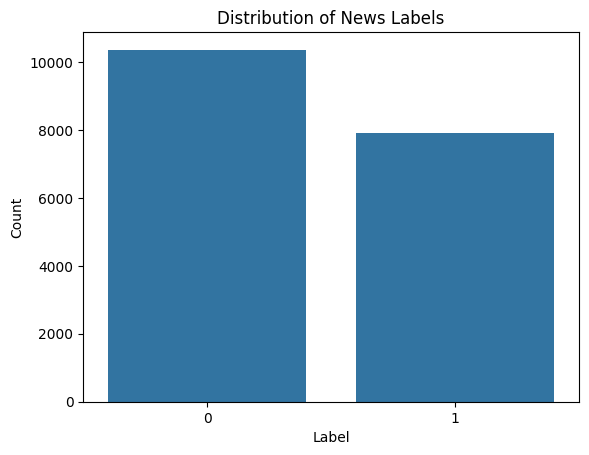

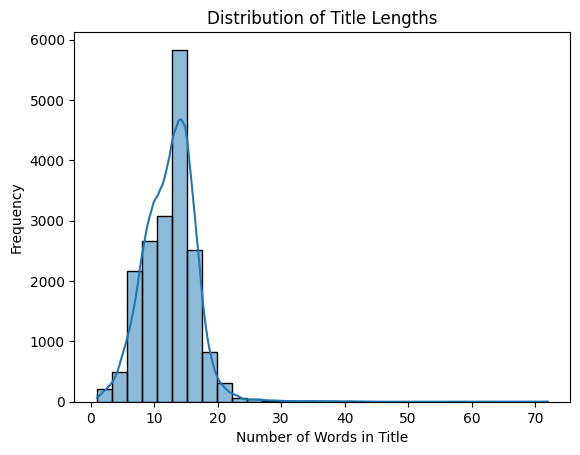

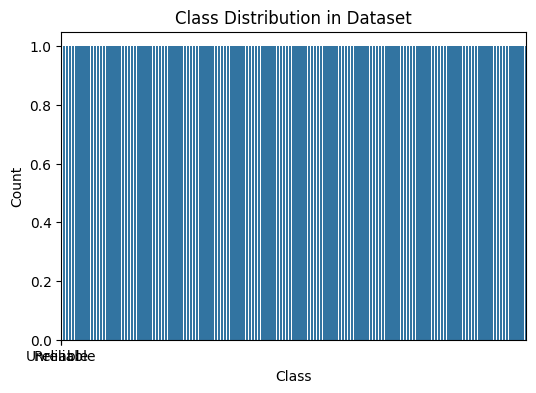

In [5]:
# Visualizing the distribution of labels
sns.countplot(x='label', data=train_clean)
plt.title('Distribution of News Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Visualizing the length of titles in the dataset
train_clean['title_length'] = train_clean['title'].apply(lambda x: len(x.split()))
sns.histplot(train_clean['title_length'], bins=30, kde=True)
plt.title('Distribution of Title Lengths')
plt.xlabel('Number of Words in Title')
plt.ylabel('Frequency')
plt.show()

# Plot class distribution
def plot_class_distribution(labels, title='Class Distribution'):
    plt.figure(figsize=(6, 4))
    sns.countplot(labels)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Reliable', 'Unreliable'])
    plt.show()

plot_class_distribution(train_clean['label'], title='Class Distribution in Dataset')


5. Prepare Data for Modeling
---------------------

In [6]:
# Vocabulary size and sentence length
voc_size = 10000
sent_length = 20

# Tokenization and Padding
tokenizer = Tokenizer(num_words=voc_size, oov_token="<OOV>")
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

# Pad sequences
X_final = pad_sequences(sequences, maxlen=sent_length, padding='post')
y_final = np.array(y)


6. Load Pre-trained Word Embeddings
---------------------------


In [7]:
from gensim.models import KeyedVectors
import gensim.downloader as api

# Load pre-trained GloVe embeddings
embedding_model = api.load('glove-wiki-gigaword-100')

# Create embedding matrix
embedding_dim = 100

def create_embedding_matrix(word_index, embedding_model, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in embedding_model:
            embedding_vector = embedding_model[word]
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.normal(0, 0.1, embedding_dim)
    return embedding_matrix

embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_model, embedding_dim)


7. Train/Test Split
-------------------------

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (12250, 20)
Testing set size: (6035, 20)


8. Build and Train Models
-----------------------------

Bidirectional LSTM Model


---------------

In [9]:
# Build the Bidirectional LSTM model
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=sent_length,
                            trainable=False))
model_bi_lstm.add(Bidirectional(LSTM(100)))
model_bi_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_bi_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_bi_lstm = model_bi_lstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8073 - loss: 0.3705 - val_accuracy: 0.9112 - val_loss: 0.2125
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9228 - loss: 0.1814 - val_accuracy: 0.9107 - val_loss: 0.1859
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9359 - loss: 0.1535 - val_accuracy: 0.9210 - val_loss: 0.1771
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9456 - loss: 0.1317 - val_accuracy: 0.9271 - val_loss: 0.1721
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9496 - loss: 0.1181 - val_accuracy: 0.9279 - val_loss: 0.1766


LSTM with Attention Mechanism

------------

In [10]:
from keras_self_attention import SeqSelfAttention

# Build the LSTM model with attention
model_attention = Sequential()
model_attention.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                              output_dim=embedding_dim,
                              weights=[embedding_matrix],
                              input_length=sent_length,
                              trainable=False))
model_attention.add(Bidirectional(LSTM(64, return_sequences=True)))
model_attention.add(SeqSelfAttention(attention_activation='sigmoid'))
model_attention.add(tf.keras.layers.Flatten())
model_attention.add(Dense(1, activation='sigmoid'))

# Compile the model
model_attention.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_attention = model_attention.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7937 - loss: 0.3876 - val_accuracy: 0.9128 - val_loss: 0.1979
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9202 - loss: 0.1823 - val_accuracy: 0.9188 - val_loss: 0.1861
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9358 - loss: 0.1480 - val_accuracy: 0.9216 - val_loss: 0.1783
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9483 - loss: 0.1241 - val_accuracy: 0.9291 - val_loss: 0.1787
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9585 - loss: 0.1044 - val_accuracy: 0.9264 - val_loss: 0.1949


8. Model Evaluation

----------------
Evaluate Bidirectional LSTM Model


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Bidirectional LSTM Model Accuracy: 0.93


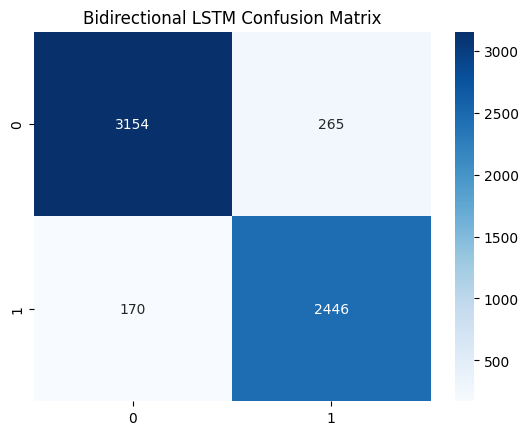

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3419
           1       0.90      0.94      0.92      2616

    accuracy                           0.93      6035
   macro avg       0.93      0.93      0.93      6035
weighted avg       0.93      0.93      0.93      6035



In [11]:
# Evaluate the model on the test set
y_pred_bi_lstm = (model_bi_lstm.predict(X_test) > 0.5).astype(int)

# Calculate accuracy
accuracy_bi_lstm = accuracy_score(y_test, y_pred_bi_lstm)
print(f'Bidirectional LSTM Model Accuracy: {accuracy_bi_lstm:.2f}')

# Confusion matrix
conf_matrix_bi_lstm = confusion_matrix(y_test, y_pred_bi_lstm)
sns.heatmap(conf_matrix_bi_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('Bidirectional LSTM Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_bi_lstm))


Evaluate Attention Model


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Attention Model Accuracy: 0.93


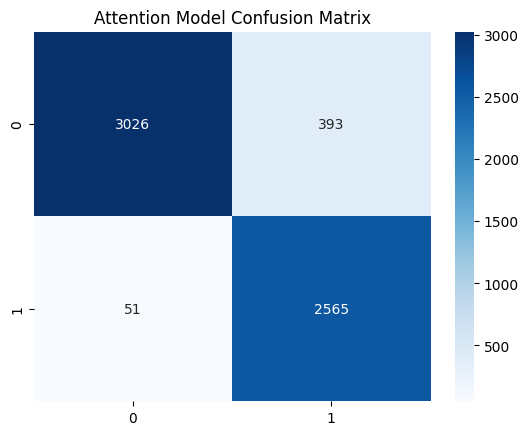

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      3419
           1       0.87      0.98      0.92      2616

    accuracy                           0.93      6035
   macro avg       0.93      0.93      0.93      6035
weighted avg       0.93      0.93      0.93      6035



In [12]:
# Evaluate the model on the test set
y_pred_attention = (model_attention.predict(X_test) > 0.5).astype(int)

# Calculate accuracy
accuracy_attention = accuracy_score(y_test, y_pred_attention)
print(f'Attention Model Accuracy: {accuracy_attention:.2f}')

# Confusion matrix
conf_matrix_attention = confusion_matrix(y_test, y_pred_attention)
sns.heatmap(conf_matrix_attention, annot=True, fmt='d', cmap='Blues')
plt.title('Attention Model Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_attention))


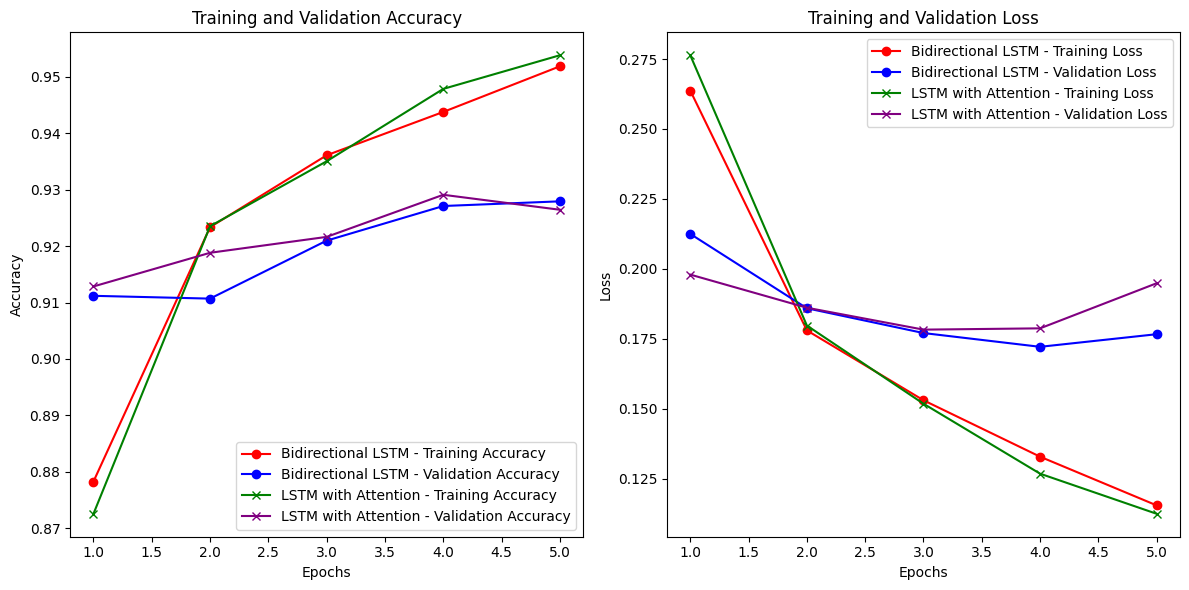

In [13]:
# Function to plot accuracy and loss for both models
def plot_training_history(history_bi_lstm, history_attention):
    epochs = range(1, 6)  # 5 epochs

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_bi_lstm.history['accuracy'], label='Bidirectional LSTM - Training Accuracy', color='red', marker='o')
    plt.plot(epochs, history_bi_lstm.history['val_accuracy'], label='Bidirectional LSTM - Validation Accuracy', color='blue', marker='o')
    plt.plot(epochs, history_attention.history['accuracy'], label='LSTM with Attention - Training Accuracy', color='green', marker='x')
    plt.plot(epochs, history_attention.history['val_accuracy'], label='LSTM with Attention - Validation Accuracy', color='purple', marker='x')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_bi_lstm.history['loss'], label='Bidirectional LSTM - Training Loss', color='red', marker='o')
    plt.plot(epochs, history_bi_lstm.history['val_loss'], label='Bidirectional LSTM - Validation Loss', color='blue', marker='o')
    plt.plot(epochs, history_attention.history['loss'], label='LSTM with Attention - Training Loss', color='green', marker='x')
    plt.plot(epochs, history_attention.history['val_loss'], label='LSTM with Attention - Validation Loss', color='purple', marker='x')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history_bi_lstm, history_attention)


ROC and Precision-Recall Curves


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


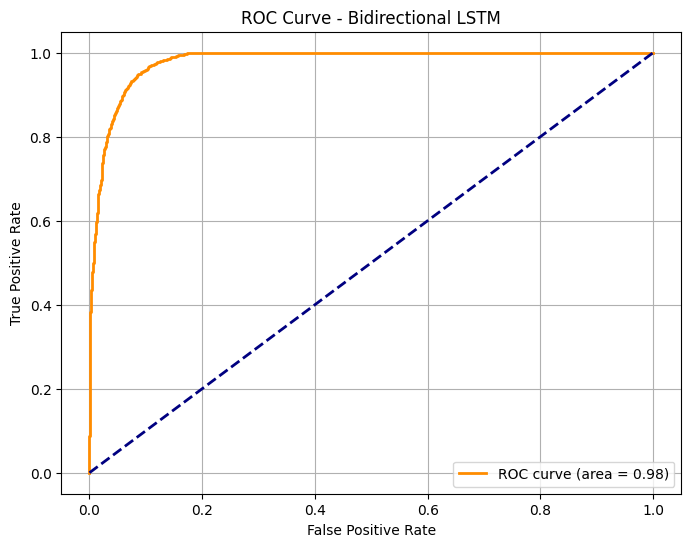

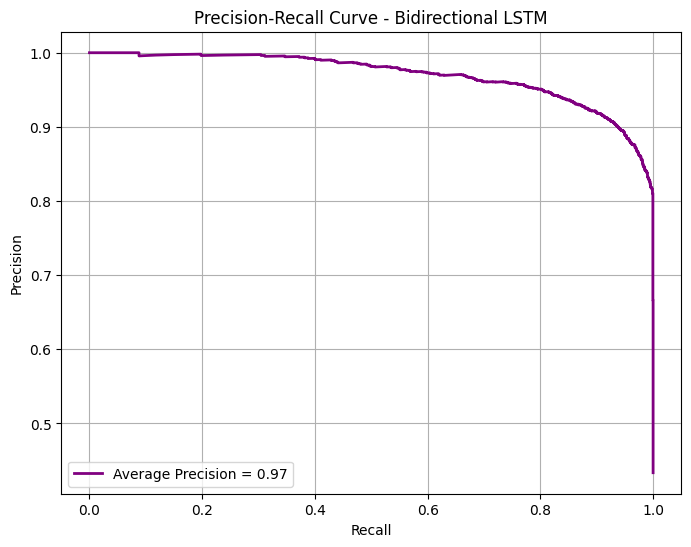

In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Plot ROC Curve
def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Get predicted probabilities
y_scores_bi_lstm = model_bi_lstm.predict(X_test).ravel()

# Plot ROC curve
plot_roc_curve(y_test, y_scores_bi_lstm, title='ROC Curve - Bidirectional LSTM')

# Plot Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_scores, title='Precision-Recall Curve'):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='purple', lw=2,
             label='Average Precision = %0.2f' % average_precision)
    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

# Plot Precision-Recall curve
plot_precision_recall_curve(y_test, y_scores_bi_lstm, title='Precision-Recall Curve - Bidirectional LSTM')


10. Hyperparameter Tuning
----------------------

In [15]:
import keras_tuner as kt

# Define a function to build and train the model
def build_and_train_model(units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=sent_length,
                        trainable=False))
    model.add(Bidirectional(LSTM(units=units)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    
    # Evaluate the model
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Units: {units}, Dropout: {dropout_rate}, LR: {learning_rate}, Accuracy: {accuracy:.4f}')
    return accuracy

# Hyperparameter search
units_list = [50, 100]
dropout_list = [0.0, 0.2]
learning_rate_list = [1e-3, 1e-4]

best_accuracy = 0
best_params = {}

for units in units_list:
    for dropout_rate in dropout_list:
        for learning_rate in learning_rate_list:
            accuracy = build_and_train_model(units, dropout_rate, learning_rate)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'units': units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}

print(f'Best Accuracy: {best_accuracy:.4f} with parameters: {best_params}')


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Units: 50, Dropout: 0.0, LR: 0.001, Accuracy: 0.9279
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Units: 50, Dropout: 0.0, LR: 0.0001, Accuracy: 0.9087
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Units: 50, Dropout: 0.2, LR: 0.001, Accuracy: 0.9213
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Units: 50, Dropout: 0.2, LR: 0.0001, Accuracy: 0.9052
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Units: 100, Dropout: 0.0, LR: 0.001, Accuracy: 0.9299
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Units: 100, Dropout: 0.0, LR: 0.0001, Accuracy: 0.9140
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Units: 100, Dropout: 0.2, LR: 0.001, Accuracy: 0.9294
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Units: 100, Dropout: 0.2, LR: 0.0001, Accuracy: 0.9112
Best Accuracy: 0.9299 with parameters: {'units': 100, 'dropout_rate': 0.0, 'learning_rate': 0.001}


11. k-Fold Cross-Validation

-----------------

In [16]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, test_idx in kfold.split(X_final):
    model_cv = clone_model(model_bi_lstm)
    model_cv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_cv.fit(X_final[train_idx], y_final[train_idx], epochs=3, batch_size=64, verbose=0)
    scores = model_cv.evaluate(X_final[test_idx], y_final[test_idx], verbose=0)
    print(f'Fold Accuracy: {scores[1]*100:.2f}%')
    cv_scores.append(scores[1] * 100)

# Display average performance
print(f'Mean Accuracy: {np.mean(cv_scores):.2f}% (± {np.std(cv_scores):.2f}%)')


Fold Accuracy: 88.73%
Fold Accuracy: 90.02%
Fold Accuracy: 90.95%
Fold Accuracy: 89.31%
Fold Accuracy: 90.29%
Mean Accuracy: 89.86% (± 0.77%)


12. Visualize Word Embeddings
------------------


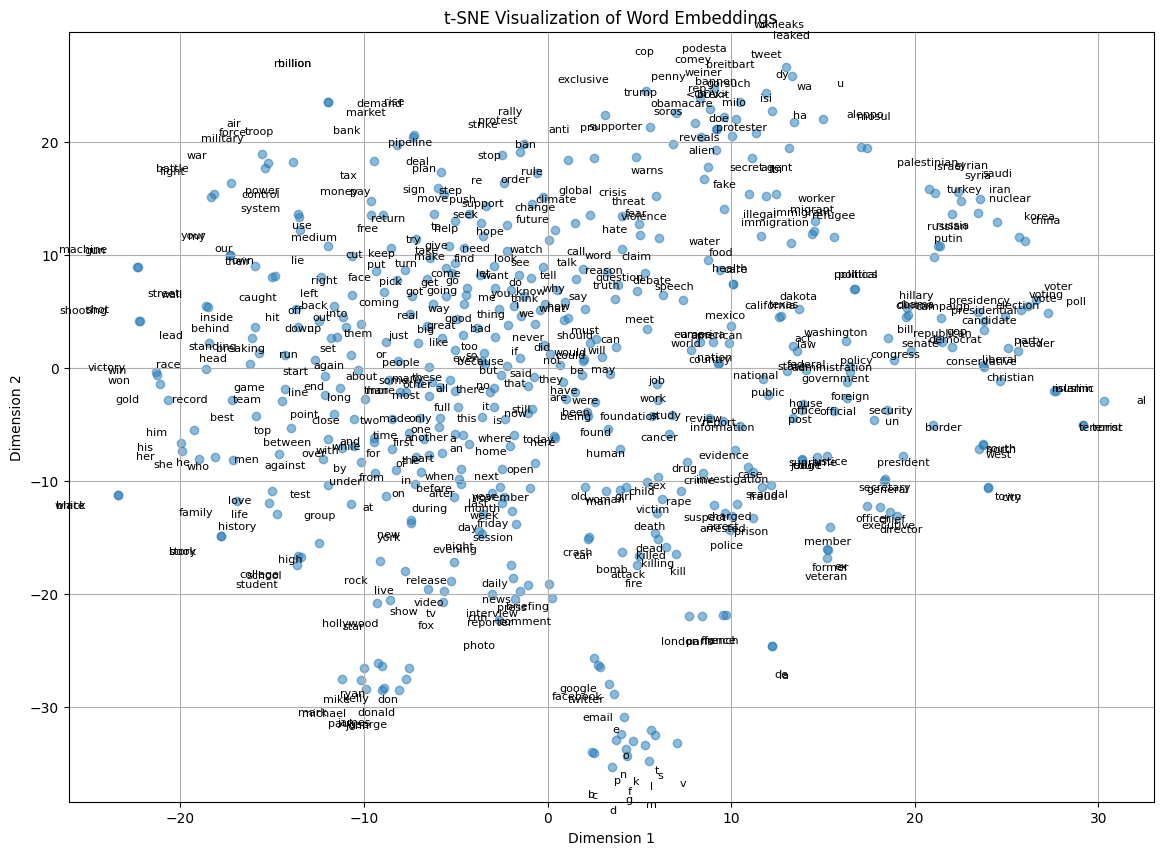

In [17]:
from sklearn.manifold import TSNE

# Get word embeddings excluding the padding token
word_embeddings = embedding_matrix[1:]  # Exclude the embedding for index 0

# Create index_to_word mapping
index_to_word = {index: word for word, index in tokenizer.word_index.items() if index != 0}

# Sort indices to align words with embeddings
sorted_indices = sorted(index_to_word.keys())

# Create a list of words sorted by their index
words_sorted = [index_to_word[index] for index in sorted_indices]

# Limit to first 500 embeddings for visualization
num_embeddings = 500
embeddings_to_use = word_embeddings[:num_embeddings]
words_to_plot = words_sorted[:num_embeddings]

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings_to_use)

# Plot the embeddings
plt.figure(figsize=(14, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

for i, word in enumerate(words_to_plot):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]), textcoords='offset points', ha='right', va='bottom', fontsize=8)

plt.title('t-SNE Visualization of Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


13. Clustering Word Embeddings with K-Means
-----------------

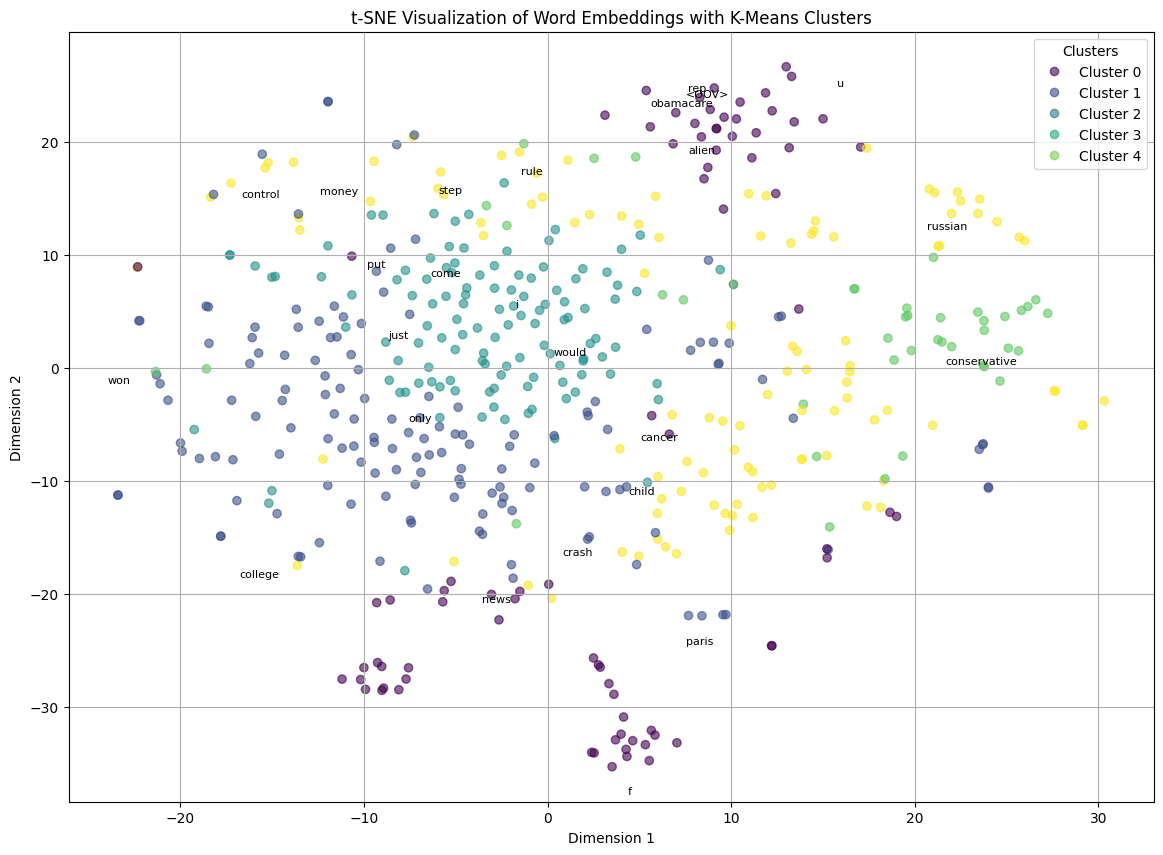

In [18]:
from sklearn.cluster import KMeans

# Cluster the embeddings
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(embeddings_to_use)

# Plot the embeddings with cluster colors
plt.figure(figsize=(14, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)

# Add a legend for clusters
handles, labels = scatter.legend_elements(prop='colors', num=num_clusters)
plt.legend(handles, [f'Cluster {i}' for i in range(num_clusters)], title='Clusters')

# Annotate a subset of words to avoid clutter
for i, word in enumerate(words_to_plot):
    if i % 20 == 0:
        plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]), textcoords='offset points', ha='right', va='bottom', fontsize=8)

plt.title('t-SNE Visualization of Word Embeddings with K-Means Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


14. Visualizing Misclassified Samples
-------------------------

In [19]:
def display_misclassified_samples(X_test, y_test, y_pred, tokenizer, num_samples=5):
    misclassified_indices = np.where(y_test != y_pred.squeeze())[0]
    print(f"Total misclassified samples: {len(misclassified_indices)}\n")

    oov_token_index = tokenizer.word_index.get(tokenizer.oov_token)
    oov_token_word = tokenizer.index_word.get(oov_token_index, '') if oov_token_index else ''

    for idx in misclassified_indices[:num_samples]:
        sequence = X_test[idx]
        words = []
        for idx_word in sequence:
            word = tokenizer.index_word.get(idx_word)
            if word is not None:
                words.append(word)
            elif tokenizer.oov_token is not None and oov_token_word:
                words.append(oov_token_word)
        text = ' '.join(words)
        actual_label = 'Unreliable' if y_test[idx] == 1 else 'Reliable'
        predicted_label = 'Unreliable' if y_pred[idx][0] == 1 else 'Reliable'
        print(f"Text: {text}")
        print(f"Actual Label: {actual_label}, Predicted Label: {predicted_label}\n")


15. Word Cloud Visualization
----------------

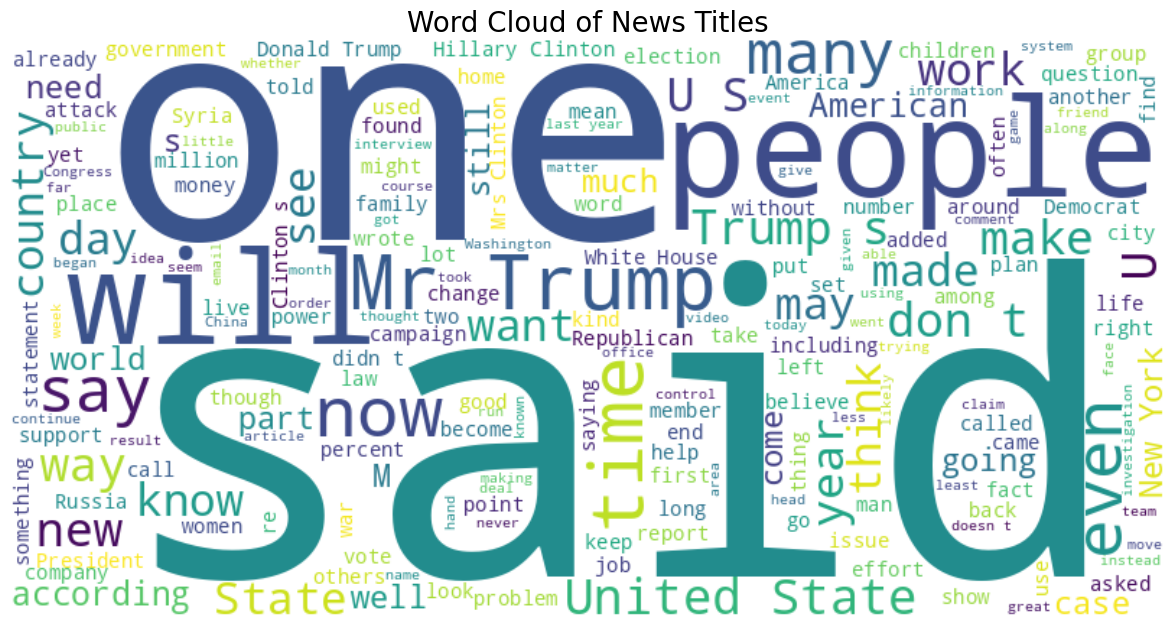

In [20]:
from wordcloud import WordCloud

def plot_word_cloud(corpus, title='Word Cloud'):
    text = ' '.join(corpus)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()


plot_word_cloud(train_clean['text'], title='Word Cloud of News Titles')


1. Word Frequency Analysis


Overall Word Frequency


In [21]:
# 16. Word Frequency Analysis
# --------------------

# %%
from collections import Counter

# Flatten the corpus into a single list of words
all_words = ' '.join(corpus).split()

# Get the frequency distribution of words
word_freq = Counter(all_words)

# Most common words
most_common_words = word_freq.most_common(20)
print("Most Common Words in Corpus:")
for word, freq in most_common_words:
    print(f'{word}: {freq}')


Most Common Words in Corpus:
the: 11119
new: 7024
time: 6478
york: 6342
to: 4982
s: 4018
a: 3701
in: 3580
trump: 3493
of: 3431
breitbart: 2402
for: 2258
and: 2217
on: 2184
is: 1700
hillary: 1123
clinton: 1120
with: 1115
at: 1018
u: 993


Visualize Word Frequencies
--------------------

We'll create a bar plot to visualize the most common words.



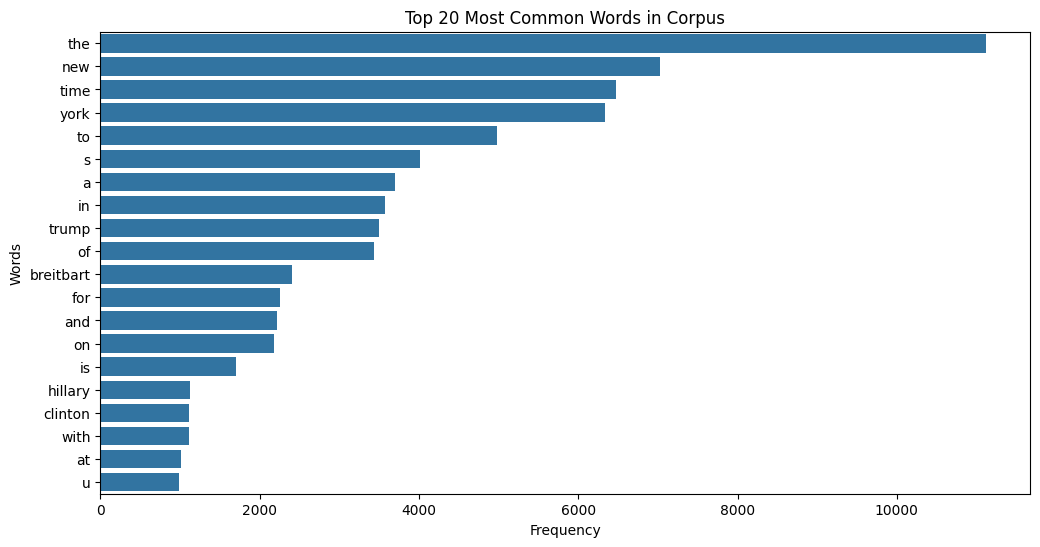

In [22]:
# %%
# Visualize the most common words
words = [word for word, freq in most_common_words]
frequencies = [freq for word, freq in most_common_words]

plt.figure(figsize=(12, 6))
sns.barplot(x=frequencies, y=words)
plt.title('Top 20 Most Common Words in Corpus')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


Word Frequency per Class


-----------------
Calculate and visualize the most common words in each class (Reliable and Unreliable).



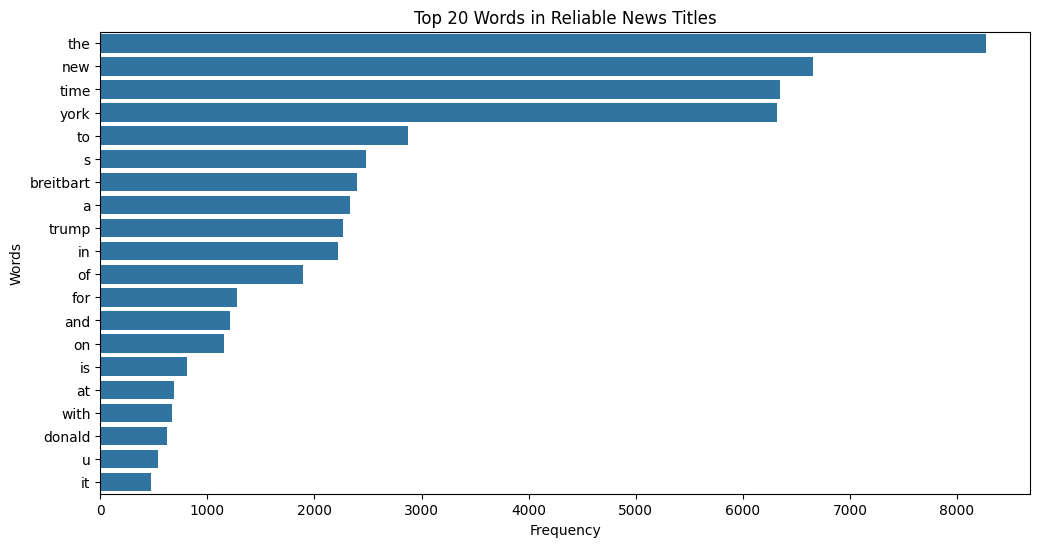

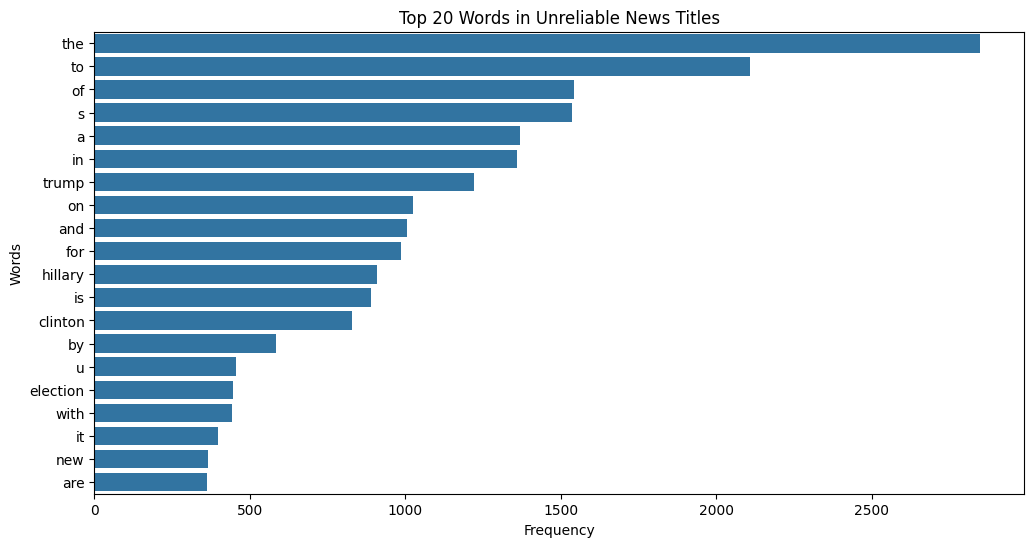

In [23]:
# %%
# Separate corpus based on labels
corpus_reliable = [corpus[i] for i in range(len(corpus)) if y_final[i] == 0]
corpus_unreliable = [corpus[i] for i in range(len(corpus)) if y_final[i] == 1]

# Function to get most common words in a corpus
def get_most_common_words(corpus, num_words=20):
    all_words = ' '.join(corpus).split()
    word_freq = Counter(all_words)
    return word_freq.most_common(num_words)

# Get most common words for each class
most_common_reliable = get_most_common_words(corpus_reliable)
most_common_unreliable = get_most_common_words(corpus_unreliable)

# Visualize
def plot_most_common_words(most_common_words, title):
    words = [word for word, freq in most_common_words]
    frequencies = [freq for word, freq in most_common_words]
    plt.figure(figsize=(12, 6))
    sns.barplot(x=frequencies, y=words)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

plot_most_common_words(most_common_reliable, 'Top 20 Words in Reliable News Titles')
plot_most_common_words(most_common_unreliable, 'Top 20 Words in Unreliable News Titles')


2. Important Words for Classification


We can analyze which words are most influential in distinguishing between classes by looking at the coefficients of the Logistic Regression model.



In [26]:
# %% [markdown]
# 23. t-SNE Visualization of Documents
# --------------------

# %%
from sklearn.manifold import TSNE

# Reduce dimensionality to 50 before t-SNE to speed up
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_final, palette='viridis', alpha=0.7)
plt.title('t-SNE Visualization of Documents')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Label', labels=['Reliable', 'Unreliable'])
plt.show()


NameError: name 'X_tfidf' is not defined